In [102]:
import numpy as np
from numpy import float32
import warnings
import os
import sys
import glob
import tensorflow as tf
import cv2
from sklearn import utils
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
from pathlib import Path

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras.utils import *
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

sys.path.append(os.path.join(Path.cwd(), 'utils'))

from utils.im_utils import *
from utils.data_augmentation import *
from utils.resnet_model import *
from utils.lstm_model import *
from utils.simple_conv_model import *

In [103]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [104]:
IMG_SIZE=128

In [105]:
FLARE_CLASS = 'ALL'

LSTM_CHECKPOINTS_DIR = './checkpoints/lstm_checkpoints'
RESNET_CHECKPOINTS_DIR = './checkpoints/resnet_checkpoints'

# AUG_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/train'
# AUG_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/val'
# AUG_TEST_DATA_DIR = f'./data/{FLARE_CLASS}_data_augmented/test'

TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/train'
VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/val'
TEST_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended/test'

AUG_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended_augmented/train'
AUG_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended_augmented/val'
AUG_TEST_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_extended_augmented/test'

AUG_PAIR_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/train'
AUG_PAIR_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/val'
AUG_PAIR_TEST_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented_pair/test'

AUG_END_PAIR_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_end_data_augmented_pair/train'
AUG_END_PAIR_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_end_data_augmented_pair/val'
AUG_END_PAIR_TEST_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_end_data_augmented_pair/test'

AUG_ALL_CLASS_TRAIN_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented/train'
AUG_ALL_CLASS_VAL_DATA_DIR = f'./data/{FLARE_CLASS}_lstm_data_augmented/val'

# DATA_FEATURES_DIR = './data/data_features_simple'
# DATA_FEATURES_TRAIN_DIR = './data/data_features_simple/train'
# DATA_FEATURES_VAL_DIR = './data/data_features_simple/val'
# DATA_FEATURES_TEST_DIR = './data/data_features_simple/test'

In [106]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [107]:
def GetDataFolders(train_data_dir, val_data_dir, test_data_dir):
    train_folders = []
    for subdir, dirs, files in os.walk(train_data_dir):
        for d in dirs:
            if d != 'positive' and d != 'negative' and d != '.ipynb_checkpoints':
                train_folders.append(os.path.join(subdir, d))
    train_folders = np.array(train_folders)

    val_folders = []
    for subdir, dirs, files in os.walk(val_data_dir):
         for d in dirs:
                if d != 'positive' and d != 'negative' and d != '.ipynb_checkpoints':
                    val_folders.append(os.path.join(subdir, d))
    val_folders = np.array(val_folders)

    test_folders = []
    for subdir, dirs, files in os.walk(test_data_dir):
         for d in dirs:
                if d != 'positive' and d != 'negative' and d != '.ipynb_checkpoints':
                    test_folders.append(os.path.join(subdir, d))
    test_folders = np.array(test_folders)
    
    return train_folders, val_folders, test_folders

In [108]:
def GetPairDataFolders(train_data_dir, val_data_dir):
    train_folders = set()
    for subdir, dirs, files in os.walk(train_data_dir):
        for f in files:
            file_parent_path = os.path.join(subdir, f).rsplit('/', 2)[0]
            train_folders.add(file_parent_path)

    val_folders = set()
    for subdir, dirs, files in os.walk(val_data_dir):
        for f in files:
            file_parent_path = os.path.join(subdir, f).rsplit('/', 2)[0]
            val_folders.add(file_parent_path)
    
    return list(train_folders), list(val_folders)

In [109]:
def get_labels(generator, feature_extractor):
    labels = []

    for sample in generator:
        new_batch = []
        batch = sample[1]
        labels.append(batch)

    labels = np.array(labels)
    labels = labels.reshape(labels.shape[0]*labels.shape[1], labels.shape[2])
    
    return labels

In [110]:
def CustomAlexNet1():
    inp = Input(shape=(128, 128, 1))
    x = Conv2D(filters=96, kernel_size=(11, 11), activation='relu')(inp)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(3, 3))(x)
    
    x = Conv2D(filters=256, kernel_size=(5, 5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(3, 3))(x)
    
    x = Conv2D(filters=384, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters=384, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = MaxPool2D(pool_size=(3, 3))(x)
    
    x = Flatten()(x)
    
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, x)
    
    return model

In [111]:
def CustomPairAlexNet(batch_size):
    inp = Input(shape=(2, 128, 128, 1))
    cutout_inp = tf.convert_to_tensor([inp[x][0] for x in range(batch_size)])
    full_inp = tf.convert_to_tensor([inp[x][1] for x in range(batch_size)])
    # full_inp = Input(shape=(128, 128, 1))
    
    cutout_features = CustomAlexNet1()(cutout_inp)
    full_features = CustomAlexNet1()(full_inp)
    print(full_features.shape)
    
    x = concatenate([cutout_features, full_features])
    # x = cutout_features
    # x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, x)
    
    return model

In [112]:
class FullImageAllClassGen(tf.keras.utils.Sequence):
    
    def __init__(self, folder_paths,
                 batch_size,
                 shuffle=True,
                num_classes=4):
        
        self.folder_paths = folder_paths.copy()
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = 6
        
        self.n = len(self.folder_paths)
        self.n_category = num_classes
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.folder_paths)
    
    def __getitem__(self, index):
        batches = self.folder_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)  
        X = np.expand_dims(X, axis=4)
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __get_input(self, folder):
        images = []
        for subdir, dirs, files in os.walk(folder):
            for f in files:
                images.append(os.path.join(subdir, f))
        images = sorted(images)
        images = [np.load(x) for x in images[:self.sequence_length]]
        images = [abs(images[x]-images[x-1]) for x in range(1, self.sequence_length)]
        # if len(images) != 2:
        #     print(folder)
        images = [cv2.resize(x, (128, 128), interpolation = cv2.INTER_AREA) for x in images]
        # images = [sigma_clip(x) for x in images]
        images  = np.array(images)
        return images

    def __get_output(self, path):
        label = None
        folder = path.rsplit('/')[-3]
        if folder == 'N':
            label = 0
        elif folder == 'C':
            label = 1
        elif folder == 'M':
            label = 2
        elif folder == 'X':
            label = 3
        
        one_hot_label = tf.one_hot(label, self.n_category)
        
        return one_hot_label
    
    def __get_data(self, batches):
        X_batch = np.asarray([self.__get_input(x) for x in batches])
        y_batch = np.asarray([self.__get_output(y) for y in batches])

        return X_batch, y_batch

In [127]:
batch_size=16
# train_folders, val_folders = GetPairDataFolders(AUG_END_PAIR_TRAIN_DATA_DIR, AUG_END_PAIR_VAL_DATA_DIR)
# train_folders, val_folders = GetPairDataFolders(AUG_PAIR_TRAIN_DATA_DIR, AUG_PAIR_VAL_DATA_DIR)
train_folders, val_folders = GetPairDataFolders(AUG_ALL_CLASS_TRAIN_DATA_DIR, AUG_ALL_CLASS_VAL_DATA_DIR)
traingen = FullImageAllClassGen(train_folders[:len(train_folders)//4], batch_size)
valgen = FullImageAllClassGen(val_folders, batch_size)

In [114]:
def CustomLSTMPairAlexNet(batch_size, feature_extractor):
    # first 6 images are full size, last 6 are cutouts
    inp = Input(shape=(12, 128, 128, 1))
    full_inp = tf.convert_to_tensor([inp[x][0:6] for x in range(batch_size)])
    cutout_inp = tf.convert_to_tensor([inp[x][6:12] for x in range(batch_size)])
    pairs = tf.convert_to_tensor([[cutout_inp[x], full_inp[x]] for x in range(batch_size)])
    pairs = tf.reshape(pairs, (pairs.shape[0], pairs.shape[2], pairs.shape[1], pairs.shape[3], pairs.shape[4]))
    pairs = tf.expand_dims(pairs, 5)
    print(pairs.shape)
    features = []
    for i in range(6):
        cur_layer = pairs[:, i, :, :, :, :]
        print(cur_layer.shape)
        features.append(feature_extractor(cur_layer))
    features = tf.convert_to_tensor(features)
    x = tf.reshape(features, (features.shape[1], features.shape[0], features.shape[2]))
    print(x.shape)
    # x = TimeDistributed(feature_extractor)(pairs)
    # x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = LSTM(128, dropout=0.1, return_sequences=True)(x)
    x = LSTM(64, dropout=0.1)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inp, x)
    
    return model

In [115]:
def SingleConvLSTMModel(batch_size, sequence_length):
    # Construct the input layer with no definite frame size.
    inp = Input(shape=(sequence_length, 128, 128, 1))

    # We will construct 3 `ConvLSTM2D` layers with batch normalization,
    # followed by a `Conv3D` layer for the spatiotemporal outputs.
    x = Bidirectional(ConvLSTM2D(
        filters=32,
        kernel_size=(5, 5),
        padding="same",
        return_sequences=True,
        activation="relu",
    ))(inp)
    x = BatchNormalization()(x)
    x = Bidirectional(ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    ))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(ConvLSTM2D(
        filters=32,
        kernel_size=(1, 1),
        padding="same",
        return_sequences=True,
        activation="relu",
    ))(x)
    # x = layers.Conv3D(
    #     filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    # )(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    # x = GlobalMaxPooling3D()(x)
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.4)(x)
    # x = Dense(1, activation='sigmoid')(x)
    
    # Next, we will build the complete model and compile it.
    model = Model(inp, x)
    
    return model

In [116]:
# def ConvLSTMModel(batch_size):
#     inp = Input(shape=(6, 64, 64, 1))
#     print(inp.shape)
#     full_inp = inp#tf.convert_to_tensor(inp[:, :6, :, :, :])
#     # cutout_inp = tf.convert_to_tensor(inp[:, 6:, :, :, :])
    
#     x = SingleConvLSTMModel(batch_size)(full_inp)
#     x = GlobalMaxPooling3D()(x)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.4)(x)
#     x = Dense(1, activation='sigmoid')(x)
#     model = Model(inp, x)
    
#     return model

In [117]:
def ConvLSTMModelAllClass(batch_size, sequence_length, num_classes=4):
    inp = Input(shape=(sequence_length, 128, 128, 1))
    print(inp.shape)
    full_inp = inp#tf.convert_to_tensor(inp[:, :6, :, :, :])
    # cutout_inp = tf.convert_to_tensor(inp[:, 6:, :, :, :])
    
    x = SingleConvLSTMModel(batch_size, sequence_length)(full_inp)
    x = GlobalMaxPooling3D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inp, x)
    
    return model

In [118]:
# def PairConvLSTMModel(batch_size):
#     inp = Input(shape=(12, 64, 64, 1))
#     print(inp.shape)
#     full_inp = tf.convert_to_tensor(inp[:, :6, :, :, :])
#     cutout_inp = tf.convert_to_tensor(inp[:, 6:, :, :, :])
    
#     full_features = SingleConvLSTMModel(batch_size)(full_inp)
#     cutout_features = SingleConvLSTMModel(batch_size)(cutout_inp)
#     x = concatenate([full_features, cutout_features])
#     x = GlobalMaxPooling3D()(x)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.4)(x)
#     x = Dense(1, activation='sigmoid')(x)
#     model = Model(inp, x)
    
#     return model

In [128]:
# model = ConvLSTMModel(batch_size)
# model = PairConvLSTMModel(batch_size)
model = ConvLSTMModelAllClass(batch_size, 5)

(None, 5, 128, 128, 1)


In [129]:
adam_fine = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-3,
decay_steps=10000,
decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(
    loss="categorical_crossentropy", optimizer=adam_fine, metrics=["accuracy"]
)

In [130]:
epochs=10
history = model.fit(traingen, validation_data=valgen, epochs=epochs)

Epoch 1/10


2022-08-22 19:13:58.643005: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


491/491 [==============================] - 1537s 3s/step - loss: 1.1204 - accuracy: 0.5233 - val_loss: 0.8220 - val_accuracy: 0.6857
Epoch 2/10
491/491 [==============================] - 1453s 3s/step - loss: 0.9560 - accuracy: 0.5858 - val_loss: 0.8443 - val_accuracy: 0.6493
Epoch 3/10
491/491 [==============================] - 1509s 3s/step - loss: 0.9163 - accuracy: 0.6045 - val_loss: 0.9709 - val_accuracy: 0.6372
Epoch 4/10
491/491 [==============================] - 1374s 3s/step - loss: 0.8199 - accuracy: 0.6506 - val_loss: 0.9570 - val_accuracy: 0.6299
Epoch 5/10
491/491 [==============================] - 1369s 3s/step - loss: 0.7614 - accuracy: 0.6837 - val_loss: 0.8953 - val_accuracy: 0.6358
Epoch 6/10
491/491 [==============================] - 1197s 2s/step - loss: 0.7802 - accuracy: 0.6777 - val_loss: 0.9704 - val_accuracy: 0.6176
Epoch 7/10
491/491 [==============================] - 1184s 2s/step - loss: 0.7057 - accuracy: 0.7219 - val_loss: 0.8225 - val_accuracy: 0.6336
Epo

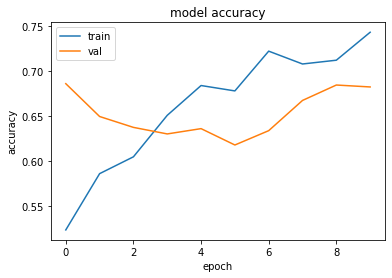

In [131]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

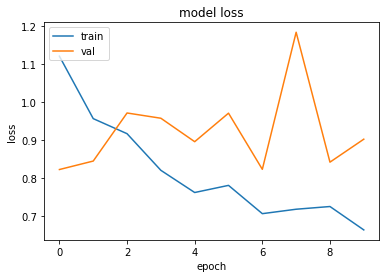

In [132]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [133]:
model.save_weights(f'{LSTM_CHECKPOINTS_DIR}/conv_lstm_trial_5')

In [74]:
val_y = [valgen[x][1] for x in range(len(valgen))]
val_y = np.array(val_y)
val_y = np.concatenate(val_y)

In [75]:
predictions = model.predict(valgen)
true_vals = val_y

correct = 0
for idx, pred in enumerate(predictions):
    pred_round = 0
    if pred >= 0.5:
        pred_round = 1
    if pred_round == true_vals[idx]:
        correct += 1

print(f'accuracy: {correct/(len(true_vals))}')

9/9 [==============================] - 4s 268ms/step
accuracy: 0.9392361111111112


In [27]:
model = CustomLSTMPairAlexNet(batch_size, feature_extractor)

NameError: name 'feature_extractor' is not defined

In [55]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

adam_fine = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
epochs=100

In [56]:
history = model.fit(traingen, validation_data=valgen, epochs=epochs)

Epoch 1/100
175/175 [==============================] - 70s 341ms/step - loss: 0.6970 - accuracy: 0.5004 - val_loss: 0.6975 - val_accuracy: 0.4688
Epoch 2/100
175/175 [==============================] - 54s 308ms/step - loss: 0.6961 - accuracy: 0.4962 - val_loss: 0.6956 - val_accuracy: 0.4969
Epoch 3/100
175/175 [==============================] - 54s 310ms/step - loss: 0.6943 - accuracy: 0.5048 - val_loss: 0.6945 - val_accuracy: 0.5094
Epoch 4/100
175/175 [==============================] - 54s 307ms/step - loss: 0.6947 - accuracy: 0.5008 - val_loss: 0.6939 - val_accuracy: 0.4844
Epoch 5/100
175/175 [==============================] - 54s 307ms/step - loss: 0.6942 - accuracy: 0.4949 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 6/100
175/175 [==============================] - 54s 307ms/step - loss: 0.6946 - accuracy: 0.4949 - val_loss: 0.6930 - val_accuracy: 0.5063
Epoch 7/100
175/175 [==============================] - 54s 307ms/step - loss: 0.6940 - accuracy: 0.5034 - val_loss: 0.6941 -

In [107]:
# feature_extractor = CustomResNet50(include_top=False)
# feature_extractor.load_weights(f'{RESNET_CHECKPOINTS_DIR}/sgd_newdata_B_class_1e-3_checkpoint')

In [108]:
# epochs = 20
# batch_size = 128

In [109]:
# train_folders, val_folders, test_folders = GetDataFolders(AUG_TRAIN_DATA_DIR, AUG_VAL_DATA_DIR, AUG_TEST_DATA_DIR)
# save_data_features(train_folders, feature_extractor)
# save_data_features(val_folders, feature_extractor)

In [110]:
# train_features, val_features, test_features = GetDataFolders(DATA_FEATURES_TRAIN_DIR, DATA_FEATURES_VAL_DIR, DATA_FEATURES_TEST_DIR)

In [111]:
# traingen = CustomDataFeaturesGen(train_features, batch_size)
# valgen = CustomDataFeaturesGen(val_features, batch_size)

In [112]:
feature_extractor = get_simple_conv_model(include_top=False)
feature_extractor.load_weights(f'{RESNET_CHECKPOINTS_DIR}/simple_conv_relu')

In [113]:
# train_folders, val_folders, test_folders = GetDataFolders(AUG_TRAIN_DATA_DIR, AUG_VAL_DATA_DIR, AUG_TEST_DATA_DIR)
# save_data_features(train_folders, feature_extractor)
# save_data_features(val_folders, feature_extractor)

In [114]:
def get_sequence_model_test():
    frame_features_input = keras.Input((6, 2048))

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)

    rnn_model = keras.Model([frame_features_input], output)
    adam_fine = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
    rnn_model.compile(
        loss="binary_crossentropy", optimizer=adam_fine, metrics=["accuracy"]
    )
    return rnn_model

In [153]:
def get_sequence_model_test3(fe):
    inp = Input(shape=(20, 64, 64, 1))
    x = tf.keras.layers.TimeDistributed(fe)(inp)
    x = tf.keras.layers.TimeDistributed(GlobalAveragePooling2D())(x)
    # x = tf.keras.layers.TimeDistributed(Flatten)(x)
    x = Dense(128, activation='relu')(x)
    x = LSTM(128, dropout=0.1, return_sequences=True)(x)
    x = LSTM(64, dropout=0.1)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, x)
    adam_fine = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    model.compile(
        loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"]
    )
    
    return model

In [154]:
epochs = 300
batch_size = 64

In [155]:
train_features, val_features, test_features = GetDataFolders(TRAIN_DATA_DIR, VAL_DATA_DIR, TEST_DATA_DIR)
traingen = CustomDataGen(train_features, batch_size)
valgen = CustomDataGen(val_features, batch_size)
testgen = CustomDataGen(test_features, batch_size)

In [156]:
model = get_sequence_model_test3(feature_extractor)
model.summary()
# history = model.fit(traingen, validation_data=valgen, epochs=epochs)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 20, 64, 64, 1)]   0         
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 19, 19, 12)   14148     
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 12)           0         
 stributed)                                                      
                                                                 
 dense_18 (Dense)            (None, 20, 128)           1664      
                                                                 
 lstm_18 (LSTM)              (None, 20, 128)           131584    
                                                                 
 lstm_19 (LSTM)              (None, 64)                494

In [31]:
predictions = model.predict(valgen[1][0])
true_vals = valgen[1][1]

correct = 0
tot_neg = 0
tot_pos = 0
for idx, pred in enumerate(predictions):
    pred_round = 0
    if pred >= 0.5:
        pred_round = 1
    if pred_round == true_vals[idx]:
        correct += 1
    if true_vals[idx] == 0:
        tot_neg += 1
    elif true_vals[idx] == 1:
        tot_pos += 1

print(f'accuracy: {correct/(len(true_vals))}')
print(f'pos/neg - {tot_pos}/{tot_neg}')

3/3 [==============================] - 0s 13ms/step
accuracy: 0.6153846153846154
pos/neg - 40/38


In [29]:
predictions

array([[0.5467096 ],
       [0.8862514 ],
       [0.13409987],
       [0.59277105],
       [0.863041  ],
       [0.6344432 ],
       [0.9966635 ],
       [0.9937004 ],
       [0.88580614],
       [0.6013978 ],
       [0.23334917],
       [0.2557678 ],
       [0.21347828],
       [0.1607935 ],
       [0.6273167 ],
       [0.5301124 ],
       [0.4377179 ],
       [0.57236296],
       [0.3340299 ],
       [0.49205497],
       [0.99559975],
       [0.27208722],
       [0.63475055],
       [0.9440781 ],
       [0.99653566],
       [0.42937624],
       [0.44375506],
       [0.78722227],
       [0.99792284],
       [0.43750167],
       [0.10135993],
       [0.9414744 ],
       [0.29670405],
       [0.99182796],
       [0.5354251 ],
       [0.08528807],
       [0.79624426],
       [0.00947714],
       [0.47564843],
       [0.6620829 ],
       [0.21594182],
       [0.9328216 ],
       [0.07231508],
       [0.97551584],
       [0.9932728 ],
       [0.9986297 ],
       [0.48612612],
       [0.112

In [76]:
def get_sequence_model_test4(input_shape):
    inp = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inp)
    x = BatchNormalization()(x)
    # x = Flatten()(x)
    x = LSTM(128, dropout=0.1, return_sequences=True)(x)
    x = LSTM(64, dropout=0.1)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inp, x)
    adam_fine = Adam(learning_rate=1, beta_1=0.9, beta_2=0.999, decay=0.0002, amsgrad=False)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    model.compile(
        loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"]
    )
    
    return model

In [34]:
model.save_weights(f'{LSTM_CHECKPOINTS_DIR}/simple_lstm_1')

In [31]:
# model.summary()

./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0136_0094_0.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0142_0094_1.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0148_0094_2.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0154_0094_3.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0200_0094_4.npy
./lstm_data/train/negative/AIA20180122_0237_0094/AIA20180122_0206_0094_5.npy


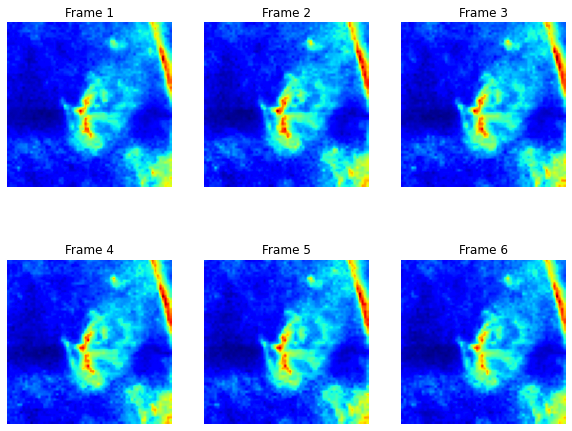

In [104]:
data_folder = './lstm_data/train/negative/AIA20180122_0237_0094'
paths = []
for subdir, dirs, files in os.walk(data_folder):
    for f in files:
        paths.append(os.path.join(subdir, f))
paths = sorted(paths)
for p in paths:
    print(p)

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(x_train)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(preprocessing.normalize(np.load(paths[idx]))), cmap='jet')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
plt.show()